<a href="https://colab.research.google.com/github/jasontancc/Can-ML-predict-stock-prices-/blob/main/Can_ML_predict_stock_prices.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Can ML predict stock prices better than technical analysis eg MACD?


In [38]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

[*********************100%***********************]  1 of 1 completed


              precision    recall  f1-score   support

          -1       0.63      0.41      0.50       424
           1       0.47      0.68      0.56       325

    accuracy                           0.53       749
   macro avg       0.55      0.55      0.53       749
weighted avg       0.56      0.53      0.52       749



<ipython-input-39-ab84567c76ae>:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ticker_data['Predicted_Signal'] = np.nan


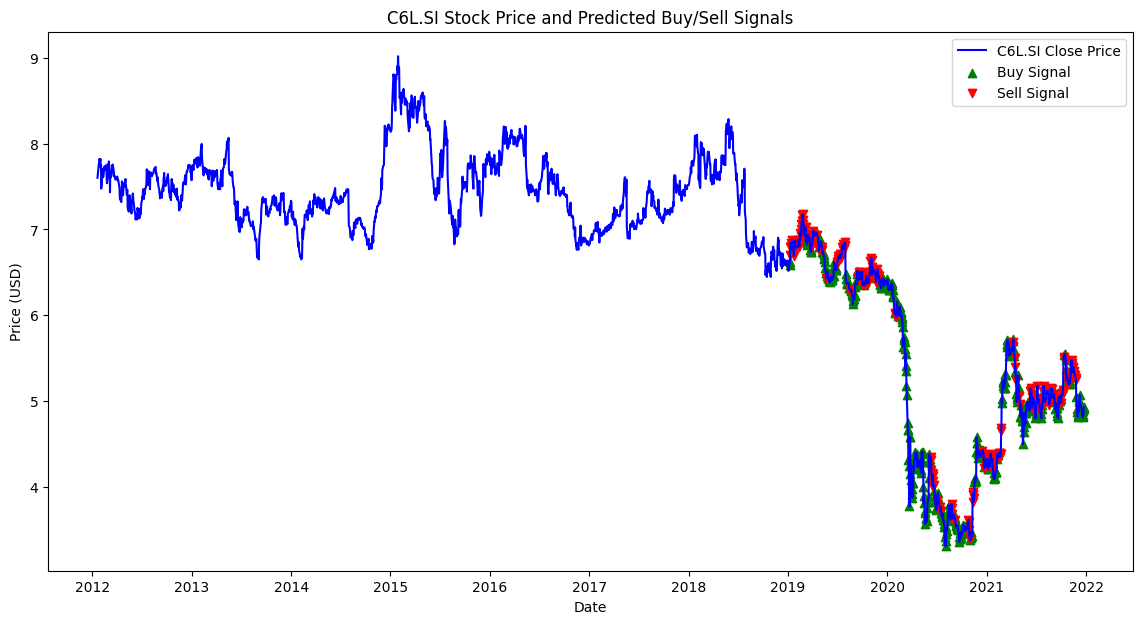

In [39]:
# Define global variables
ticker = 'C6L.SI'
start_date = '2012-01-01'
end_date = '2022-01-01'
future_days = 5
my_test_size = 0.3

# Download stock data
ticker_data = yf.download(ticker, start=start_date, end=end_date)

# Calculate additional features (Moving averages, RSI, MACD)
ticker_data['5_day_MA'] = ticker_data['Close'].rolling(window=5).mean()
ticker_data['10_day_MA'] = ticker_data['Close'].rolling(window=10).mean()

# Relative Strength Index (RSI) calculation
delta = ticker_data['Close'].diff(1)
gain = delta.where(delta > 0, 0)
loss = -delta.where(delta < 0, 0)
avg_gain = gain.rolling(window=14).mean()
avg_loss = loss.rolling(window=14).mean()
rs = avg_gain / avg_loss
ticker_data['RSI'] = 100 - (100 / (1 + rs))

# MACD and Signal Line calculation
short_ema = ticker_data['Close'].ewm(span=12, adjust=False).mean()
long_ema = ticker_data['Close'].ewm(span=26, adjust=False).mean()
macd = short_ema - long_ema
signal = macd.ewm(span=9, adjust=False).mean()
ticker_data['MACD'] = macd
ticker_data['Signal Line'] = signal

# Target: 1 if price increases in the next N days, -1 if decreases
# future_days = 5  # moved to top
ticker_data['Future_Close'] = ticker_data['Close'].shift(-future_days)
ticker_data['Target'] = np.where(ticker_data['Future_Close'] > ticker_data['Close'], 1, -1)

# Drop rows with missing values
ticker_data = ticker_data.dropna()

# Define features and target
features = ['5_day_MA', '10_day_MA', 'RSI', 'MACD', 'Signal Line']
X = ticker_data[features]
y = ticker_data['Target']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=my_test_size, shuffle=False)

# Initialize and train the Random Forest classifier
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

#### print initial training data and buy/sell signal using ML

# Classification report to evaluate performance
print(classification_report(y_test, y_pred))

# Predict buy/sell signals on the test data
ticker_data['Predicted_Signal'] = np.nan
ticker_data.iloc[-len(y_test):, ticker_data.columns.get_loc('Predicted_Signal')] = y_pred

# Plot original price and predicted buy/sell signals
plt.figure(figsize=(14,7))
plt.plot(ticker_data.index, ticker_data['Close'], label=ticker+' Close Price', color='blue')

# Mark buy/sell signals
buy_signals = ticker_data[ticker_data['Predicted_Signal'] == 1]
sell_signals = ticker_data[ticker_data['Predicted_Signal'] == -1]

plt.scatter(buy_signals.index, buy_signals['Close'], marker='^', color='green', label='Buy Signal', alpha=1)
plt.scatter(sell_signals.index, sell_signals['Close'], marker='v', color='red', label='Sell Signal', alpha=1)

plt.title(ticker+' Stock Price and Predicted Buy/Sell Signals')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()



<ipython-input-40-3770420107a1>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ticker_data['MACD_Signal'] = np.nan   # for MACD confusion matrix calculation, we need to calculate buy/sell signals based on MACD Signal
<ipython-input-40-3770420107a1>:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ticker_data['MACD_Signal'].iloc[i] = 1  # Buy signal for confusion matrix calculation, using .loc to prevent warning errors
<ipython-input-40-3770420107a1>:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats

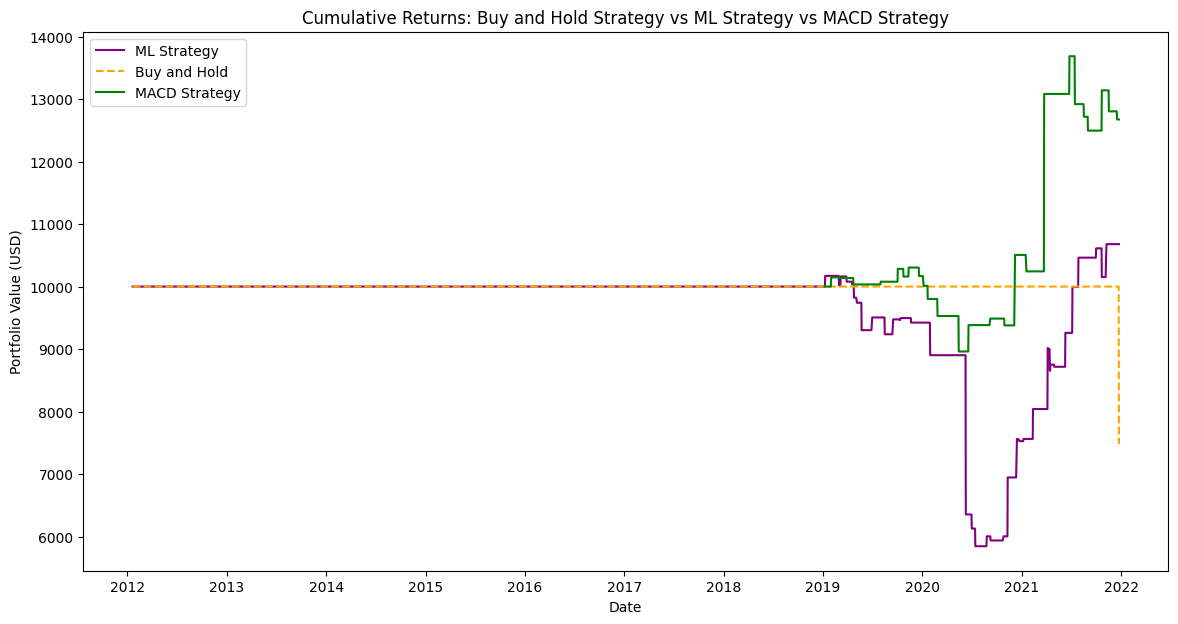

Initial Portfolio value : $10000
----------------------------------------------------------------------
                       Buy and Hold      ML Strategy     MACD Strategy
----------------------------------------------------------------------
Final Portfolio :       $7484         $10679        $12673
Accuracy % :            0%                53%               40%
CONFUSION MATRIX:
True Positive :             NA                217               11
False Positive :            NA                249               14
True Negative :             NA                164               15
False Negative :            NA                114               10
----------------------------------------------------------------------


In [40]:


# Simulate the trading strategy based on predicted signals (ML Strategy)
initial_balance = 10000  # Starting with $10,000
position = 0  # Whether we have a position in the stock (1 for holding, 0 for not holding)
balance = initial_balance
profit = 0
buy_price = 0  # The price at which the stock was bought
cumulative_returns_ml = []  # Cumulative balance for machine learning strategy

# ticker_data = ticker_data.copy()  # working with a fresh copy to avoid warning errors ??

for i in range(len(ticker_data)):
    if ticker_data['Predicted_Signal'].iloc[i] == 1 and position == 0:
        # Buy signal
        position = 1
        buy_price = ticker_data['Close'].iloc[i]
    elif ticker_data['Predicted_Signal'].iloc[i] == -1 and position == 1:
        # Sell signal
        sell_price = ticker_data['Close'].iloc[i]
        position = 0
        profit += (sell_price - buy_price) / buy_price * balance  # Calculate profit
        balance = initial_balance + profit  # Update balance
    cumulative_returns_ml.append(balance)

# Buy-and-hold strategy (Buy on first day and sell on last day)
initial_balance_bh = 10000  # Starting with $10,000
buy_price_bh = ticker_data['Close'].iloc[-len(y_test)]  # Buy on the first day of the test set
sell_price_bh = ticker_data['Close'].iloc[-1]  # Sell on the last day of the test set
profit_bh = (sell_price_bh - buy_price_bh) / buy_price_bh * initial_balance_bh
final_balance_bh = initial_balance_bh + profit_bh

# MACD Strategy
initial_balance_macd = 10000  # Starting with $10,000
balance_macd = initial_balance_macd
position_macd = 0  # Whether we have a position in the stock (1 for holding, 0 for not holding)
profit_macd = 0
buy_price_macd = 0  # The price at which the stock was bought
cumulative_returns_macd = []  # Cumulative balance for MACD strategy

# MACD Strategy Accuracy calcuation
profitable_trades_macd = 0
total_trades_macd = 0



macd_day1_index = len(ticker_data)-len(y_test)  # set first day for MACD to start on first day of test set.
ticker_data['MACD_Signal'] = np.nan   # for MACD confusion matrix calculation, we need to calculate buy/sell signals based on MACD Signal

for i in range(macd_day1_index, len(ticker_data)):
    if ticker_data['MACD'].iloc[i] > ticker_data['Signal Line'].iloc[i] and ticker_data['MACD'].iloc[i-1] <= ticker_data['Signal Line'].iloc[i-1] and position_macd == 0:
        # Buy when MACD crosses above the Signal Line
        position_macd = 1
        buy_price_macd = ticker_data['Close'].iloc[i]
        ticker_data['MACD_Signal'].iloc[i] = 1  # Buy signal for confusion matrix calculation, using .loc to prevent warning errors
    elif ticker_data['MACD'].iloc[i] < ticker_data['Signal Line'].iloc[i] and ticker_data['MACD'].iloc[i-1] >= ticker_data['Signal Line'].iloc[i-1] and position_macd == 1:
        # Sell when MACD crosses below the Signal Line
        sell_price_macd = ticker_data['Close'].iloc[i]
        position_macd = 0
        profit_macd += (sell_price_macd - buy_price_macd) / buy_price_macd * balance_macd  # Calculate profit
        balance_macd = initial_balance_macd + profit_macd  # Update balance
        ticker_data['MACD_Signal'].iloc[i] = -1  # Sell signal for confusion matrix calculation
        total_trades_macd += 1          # for MACD Strategy Accuracy calcuation
        # Check if the trade was profitable
        if sell_price_macd > buy_price_macd:
            profitable_trades_macd += 1   # for MACD Strategy Accuracy calcuation
    cumulative_returns_macd.append(balance_macd)


# Plot the cumulative returns for all three strategies
plt.figure(figsize=(14,7))

# Machine Learning Strategy Returns
plt.plot(ticker_data.index[-len(cumulative_returns_ml):], cumulative_returns_ml, label='ML Strategy', color='purple')

# Buy and Hold Strategy Returns (constant balance over the period)
cumulative_returns_bh = [initial_balance_bh] * (len(cumulative_returns_ml) - 1) + [final_balance_bh]
plt.plot(ticker_data.index[-len(cumulative_returns_ml):], cumulative_returns_bh, label='Buy and Hold', color='orange', linestyle='--')

# MACD Strategy Returns
plt.plot(ticker_data.index[-len(cumulative_returns_macd):], cumulative_returns_macd, label='MACD Strategy', color='green')

plt.title('Cumulative Returns: Buy and Hold Strategy vs ML Strategy vs MACD Strategy')
plt.xlabel('Date')
plt.ylabel('Portfolio Value (USD)')
plt.legend()

plt.show()

# Print final balances for both strategies
print(f"Initial Portfolio value : ${initial_balance}")
print("----------------------------------------------------------------------")
print("                       Buy and Hold      ML Strategy     MACD Strategy")
print("----------------------------------------------------------------------")
print(f"Final Portfolio :       ${final_balance_bh:.0f}         ${balance:.0f}        ${balance_macd:.0f}")
#print(f"Buy and Hold Strategy: ${final_balance_bh:.2f}")
#print(f"ML Strategy          : ${balance:.2f}")
#print(f"MACD Strategy        : ${balance_macd:.2f}")


# CHECK ACCURACY for each strategy

#print(" ")
#print("---------- ACCURACY IN % ---------------------")

# Buy-and-Hold Strategy Accuracy
# Buy on first day of test period, sell on last day, calculate if price increased or decreased
buy_price_bh = ticker_data['Close'].iloc[-len(y_test)]  # First day of test period
sell_price_bh = ticker_data['Close'].iloc[-1]  # Last day of test period
buy_and_hold_accuracy = 1 if sell_price_bh > buy_price_bh else 0  # 1 if price increased, 0 if not

#print(f"Buy-and-Hold Strategy Accuracy: {buy_and_hold_accuracy:.2f}")

# Machine Learning Strategy Accuracy
ml_accuracy = accuracy_score(y_test, y_pred)
#print(f"Machine Learning Strategy Accuracy: {ml_accuracy:.2f}")

# MACD Strategy Accuracy
macd_accuracy = profitable_trades_macd / total_trades_macd if total_trades_macd > 0 else 0
#print(f"MACD Strategy Accuracy: {macd_accuracy:.2f}")

print(f"Accuracy % :            {buy_and_hold_accuracy*100:.0f}%                {ml_accuracy*100:.0f}%               {macd_accuracy*100:.0f}%")


# CALCULATE CONFUSION MATRIX
# Define helper function to calculate TP, FP, TN, FN
def calculate_confusion_matrix(signal_col, ticker_data, future_days):
    tp = 0  # True Positive
    fp = 0  # False Positive
    tn = 0  # True Negative
    fn = 0  # False Negative

    for i in range(len(ticker_data) - future_days):
        signal = ticker_data[signal_col].iloc[i]
        future_close = ticker_data['Future_Close'].iloc[i]
        current_close = ticker_data['Close'].iloc[i]

        # True Positive: Buy signal and price increases in the future
        if signal == 1 and future_close > current_close:
            tp += 1
        # False Positive: Buy signal and price decreases or stays the same
        elif signal == 1 and future_close <= current_close:
            fp += 1
        # True Negative: Sell signal and price decreases in the future
        elif signal == -1 and future_close < current_close:
            tn += 1
        # False Negative: Sell signal and price increases or stays the same
        elif signal == -1 and future_close >= current_close:
            fn += 1

    return tp, fp, tn, fn

# Calculate TP, FP, TN, FN for Machine Learning Strategy
ml_tp, ml_fp, ml_tn, ml_fn = calculate_confusion_matrix('Predicted_Signal', ticker_data, future_days)

#print(f"True Positives (TP): {ml_tp}")
#print(f"False Positives (FP): {ml_fp}")
#print(f"True Negatives (TN): {ml_tn}")
#print(f"False Negatives (FN): {ml_fn}")
#print("-------------------------------------------")

# Calculate TP, FP, TN, FN for MACD Strategy
macd_tp, macd_fp, macd_tn, macd_fn = calculate_confusion_matrix('MACD_Signal', ticker_data, future_days)


#print(f"MACD Strategy Confusion Matrix:")
#print(f"True Positives (TP): {macd_tp}")
#print(f"False Positives (FP): {macd_fp}")
#print(f"True Negatives (TN): {macd_tn}")
#print(f"False Negatives (FN): {macd_fn}")

#print("  ")
print("CONFUSION MATRIX:")
print(f"True Positive :             NA                {ml_tp}               {macd_tp}")
print(f"False Positive :            NA                {ml_fp}               {macd_fp}")
print(f"True Negative :             NA                {ml_tn}               {macd_tn}")
print(f"False Negative :            NA                {ml_fn}               {macd_fn}")
print("----------------------------------------------------------------------")


# Precision - % of correct positive predictions out of total positive predictions
# Recall - % of correct positive predictions relative to total actual positives
# F1 Score - Weighted harmonice mean of precision and recall.  The closer to 1 , the better the model
# Support - number of items in the respective dataset.
